# Import

In [1]:
!pip install PyWavelets


In [2]:
import numpy as np
import pandas as pd
import json
import os
import mne
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import time # To measure time

from scipy.fft import fft
from scipy.signal import detrend, butter, filtfilt
import pywt

from skimage.transform import resize
from skimage import img_as_float, img_as_ubyte

In [3]:
def read_json_dicts (file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        data_dict = json.load(f)
    return pd.DataFrame(data_dict)

def collect_eeg_data(folder_path):
    data = {}
    for filename in os.listdir(folder_path):
        if filename.endswith(".set"):
            file_path = os.path.join(folder_path, filename)
            raw = mne.io.read_raw_eeglab(file_path, preload=True)
            data[filename] = raw.get_data()

    return data

# Preprocessing

## model 1

In [4]:
def calculate_td_psd_features(epoch_data, fs, power_lambda=0.1, epsilon=1e-9):
    """
    Calculates the 7 TD-PSD features for a single EEG epoch (single channel).
    Based on equations in Amini et al., 2021.

    Args:
        epoch_data (np.ndarray): 1D numpy array for a single channel epoch.
        fs (float): Sampling frequency of the epoch data.
        power_lambda (float): Lambda for power transform normalization.
        epsilon (float): Small value to prevent log(0) or division by zero.

    Returns:
        np.ndarray: Array containing the 7 log-transformed TD-PSD features.
                    Returns NaNs if calculation fails.
    """
    n_samples = len(epoch_data)
    if n_samples == 0:
        return np.full(7, np.nan)

    # Detrend the signal (optional but often good practice)
    signal = detrend(epoch_data)

    # 1. Calculate Power Spectrum and Moments
    try:
        # FFT
        X = fft(signal)
        # Power Spectrum (One-sided, ignoring DC for moments perhaps?)
        # Frequencies for moments k: corresponds to frequency bins
        freqs = np.fft.fftfreq(n_samples, 1/fs)
        # Power spectrum P[k] = |X[k]|^2 / N
        P = np.abs(X)**2 / n_samples

        # Calculate moments m0, m2, m4
        # m_n = sum(f^n * P(f)) df - approximated by sum(k^n * P[k])
        # We use the magnitude of frequencies for k, ignore negative freqs?
        # Let's use Hjorth parameters definition based on time-domain variance
        # m0 = variance(signal) = total power (approx)
        m0_bar = np.sum(signal**2) / n_samples # Variance = mean square if mean is zero
        if m0_bar < epsilon: m0_bar = epsilon

        # m2 = variance of first derivative (activity)
        delta_x = np.diff(signal, n=1) * fs # Scale by fs? Hjorth doesn't explicitly scale by fs
        m2_bar = np.sum(delta_x**2) / (n_samples -1) # Use n_samples-1?
        if m2_bar < epsilon: m2_bar = epsilon


        # m4 = variance of second derivative (mobility)
        delta2_x = np.diff(signal, n=2) * (fs**2) # Scale by fs^2?
        m4_bar = np.sum(delta2_x**2) / (n_samples -2)
        if m4_bar < epsilon: m4_bar = epsilon


        # Apply power transform (Box-Cox with lambda=0 is log, this is slightly different)
        m0 = (m0_bar**power_lambda - 1) / power_lambda if power_lambda != 0 else np.log(m0_bar)
        m2 = (m2_bar**power_lambda - 1) / power_lambda if power_lambda != 0 else np.log(m2_bar)
        m4 = (m4_bar**power_lambda - 1) / power_lambda if power_lambda != 0 else np.log(m4_bar)

        # Ensure moments are positive after transform for log
        m0 = max(m0, epsilon)
        m2 = max(m2, epsilon)
        m4 = max(m4, epsilon)


    except Exception as e:
        print(f"Error calculating moments: {e}")
        return np.full(7, np.nan)

    features = np.zeros(7)

    # 2. Calculate Features f1, f2, f3
    try:
        features[0] = np.log(m0) # f1 = log(m0)
        # Check for valid subtractions
        if m0 <= m2: m0 = m2 + epsilon
        if m0 <= m4: m0 = m4 + epsilon
        features[1] = np.log(m0 - m2) # f2 = log(m0 - m2)
        features[2] = np.log(m0 - m4) # f3 = log(m0 - m4)

    except Exception as e:
         print(f"Error calculating f1, f2, f3: {e}")
         features[:3] = np.nan


    # 3. Calculate Feature f4 (Sparseness)
    try:
        denominator_sqrt = np.sqrt(max(m0 - m2, epsilon)) * np.sqrt(max(m0 - m4, epsilon))
        if denominator_sqrt < epsilon: denominator_sqrt = epsilon
        features[3] = np.log(m0 / denominator_sqrt) # f4 = log(S) = log(m0 / sqrt((m0-m2)(m0-m4)))
    except Exception as e:
         print(f"Error calculating f4 (Sparseness): {e}")
         features[3] = np.nan

    # 4. Calculate Feature f5 (Irregularity Factor - IF)
    # IF = (m4/m2) / (m2/m0) based on Hjorth parameters 'complexity'
    # Paper formula: sqrt(m4/m2) / sqrt(m2/m0) => m0*m4 / m2^2
    try:
        if m2 < epsilon: m2 = epsilon
        if_val = (m0 * m4) / (m2**2)
        features[4] = np.log(max(if_val, epsilon)) # f5 = log(IF)
    except Exception as e:
        print(f"Error calculating f5 (IF): {e}")
        features[4] = np.nan

    # 5. Calculate Feature f6 (Covariance - COV)
    # COV = std_dev / mean
    try:
        mean_val = np.mean(signal)
        std_dev_val = np.std(signal)
        if abs(mean_val) < epsilon: mean_val = np.sign(mean_val) * epsilon if mean_val != 0 else epsilon
        cov_val = std_dev_val / mean_val
        features[5] = np.log(max(abs(cov_val), epsilon)) # Log of magnitude? Paper isn't explicit if COV can be negative. Let's take abs.
    except Exception as e:
        print(f"Error calculating f6 (COV): {e}")
        features[5] = np.nan


    # 6. Calculate Feature f7 (Teager Energy Operator - TEO)
    try:
        # TEO(x[j]) = x[j]^2 - x[j-1]x[j+1]
        # Need to handle boundaries (pad or slice)
        teo_vals = signal[1:-1]**2 - signal[:-2] * signal[2:]
        sum_teo = np.sum(teo_vals)
        features[6] = np.log(max(abs(sum_teo), epsilon)) # Log of magnitude? Sum can be negative. Paper isn't explicit. Taking abs.
    except Exception as e:
        print(f"Error calculating f7 (TEO): {e}")
        features[6] = np.nan

    return features


def preprocess_amini(eeg_data, fs, target_fs=256, target_duration_sec=180, epoch_len=256):
    """
    Preprocesses raw EEG data according to Amini et al. (2021).
    Selects time window, downsamples (if needed), segments, extracts TD-PSD features,
    and averages features across epochs for each channel.

    Args:
        eeg_data (np.ndarray): Raw EEG data (n_channels, n_timesteps).
        fs (float): Original sampling frequency.
        target_fs (int): Target sampling frequency (default: 256 Hz).
        target_duration_sec (int): Duration of the segment to analyze (default: 180s).
        epoch_len (int): Length of epochs for feature calculation (default: 256 samples).

    Returns:
        np.ndarray: Feature matrix (n_channels, 7), or None if error.
                   Returns NaNs for channels/features where calculation failed.
    """
    n_channels, n_timesteps = eeg_data.shape

    # 1. Select Time Window (e.g., 60s to 60s + target_duration_sec)
    start_sample = int(60 * fs) # Example: start at 60 seconds
    end_sample = start_sample + int(target_duration_sec * fs)
    if end_sample > n_timesteps:
        print(f"Warning: Data duration ({n_timesteps/fs:.2f}s) is less than required analysis window ({target_duration_sec+60}s). Using available data.")
        end_sample = n_timesteps
    if start_sample >= end_sample:
         print(f"Error: Invalid time window selection.")
         return None
    eeg_segment = eeg_data[:, start_sample:end_sample]

    # 2. Downsample (if necessary)
    if fs != target_fs:
        from scipy.signal import resample
        num_samples_resampled = int(eeg_segment.shape[1] * (target_fs / fs))
        try:
            eeg_resampled = resample(eeg_segment, num_samples_resampled, axis=1)
            current_fs = target_fs
            print(f"Resampled data from {fs}Hz to {target_fs}Hz. New shape: {eeg_resampled.shape}")
        except Exception as e:
            print(f"Error during resampling: {e}")
            return None
    else:
        eeg_resampled = eeg_segment
        current_fs = fs

    # 3. Segment into epochs and Calculate Features
    n_channels_res, n_timesteps_res = eeg_resampled.shape
    num_epochs = n_timesteps_res // epoch_len
    if num_epochs == 0:
        print(f"Error: Resampled data is shorter ({n_timesteps_res} samples) than epoch length ({epoch_len}). Cannot extract features.")
        return None

    all_channel_features = []
    for i_ch in range(n_channels_res):
        channel_data = eeg_resampled[i_ch, :]
        epoch_features_list = []
        for i_epoch in range(num_epochs):
            start = i_epoch * epoch_len
            end = start + epoch_len
            epoch = channel_data[start:end]
            features = calculate_td_psd_features(epoch, current_fs)
            if not np.isnan(features).all(): # Only add if calculation didn't fail completely
                epoch_features_list.append(features)

        if not epoch_features_list: # If no features calculated for this channel
             avg_features = np.full(7, np.nan)
        else:
            # Average features across valid epochs for the channel
            avg_features = np.nanmean(np.array(epoch_features_list), axis=0)
        all_channel_features.append(avg_features)

    # Output shape: (n_channels, 7)
    final_features = np.array(all_channel_features)
    # Optional: Flatten to a single vector per subject if needed by the specific model implementation
    # final_features = final_features.flatten() # Shape: (n_channels * 7)
    return final_features

## Model 2

In [5]:
def get_cwt_scales(fs, f_min=1, f_max=100, num_scales=128, wavelet='morl'):
    """Helper to get CWT scales corresponding to a frequency range."""
    wname = wavelet
    central_freq = pywt.central_frequency(wname)
    # Formula: scale = central_frequency * sampling_period / desired_frequency
    sampling_period = 1.0 / fs
    scales = central_freq * sampling_period / (np.logspace(np.log10(f_min), np.log10(f_max), num_scales))[::-1]
    # Frequencies corresponding to these scales (for verification)
    # frequencies = pywt.scale2frequency(wname, scales) / sampling_period
    # print(f"Generated {len(scales)} scales for freqs approx {frequencies.min()}-{frequencies.max()} Hz")
    return scales


def preprocess_acharya(eeg_data, fs, epoch_sec=5, target_size=(224, 224), wavelet='morl', scales=None):
    """
    Preprocesses raw EEG data according to Acharya et al. (2025).
    Segments data, performs CWT for each channel in each epoch, averages CWT magnitudes
    across channels, resizes to target image size, and converts to 3-channel image.

    Args:
        eeg_data (np.ndarray): Raw EEG data (n_channels, n_timesteps).
        fs (float): Original sampling frequency.
        epoch_sec (int): Duration of each epoch in seconds (default: 5s).
        target_size (tuple): Target image size (height, width) (default: (224, 224)).
        wavelet (str): Wavelet to use for CWT (default: 'morl').
        scales (np.ndarray, optional): Scales to use for CWT. If None, calculated for 1-100 Hz.

    Returns:
        list[np.ndarray]: A list of processed images (one for each epoch).
                         Each image is a numpy array of shape (height, width, 3).
                         Returns empty list if error or no full epochs.
    """
    n_channels, n_timesteps = eeg_data.shape
    samples_per_epoch = int(epoch_sec * fs)
    num_epochs = n_timesteps // samples_per_epoch

    if num_epochs == 0:
        print(f"Error: Data duration ({n_timesteps/fs:.2f}s) is less than epoch duration ({epoch_sec}s). Cannot create epochs.")
        return []

    if scales is None:
        scales = get_cwt_scales(fs, f_min=1, f_max=100, num_scales=128, wavelet=wavelet) # Example scale selection

    processed_images = []

    for i_epoch in range(num_epochs):
        start = i_epoch * samples_per_epoch
        end = start + samples_per_epoch
        epoch_data = eeg_data[:, start:end] # Shape: (n_channels, samples_per_epoch)

        all_channel_coeffs = []
        valid_channel_count = 0
        for i_ch in range(n_channels):
            try:
                # Perform CWT for the channel
                coeffs, _ = pywt.cwt(epoch_data[i_ch, :], scales, wavelet)
                # Take the magnitude (absolute value) of coefficients
                all_channel_coeffs.append(np.abs(coeffs)) # Shape: (num_scales, samples_per_epoch)
                valid_channel_count += 1
            except Exception as e:
                print(f"Warning: CWT failed for channel {i_ch}, epoch {i_epoch}: {e}")
                # Optionally append NaNs or zeros if needed, here we just skip

        if valid_channel_count == 0:
            print(f"Warning: CWT failed for all channels in epoch {i_epoch}. Skipping epoch.")
            continue

        # Average the CWT magnitudes across valid channels
        # Shape: (num_scales, samples_per_epoch)
        avg_coeffs_mag = np.mean(np.array(all_channel_coeffs), axis=0)

        # Normalize the averaged magnitudes (e.g., to 0-1 range for image representation)
        min_val = np.min(avg_coeffs_mag)
        max_val = np.max(avg_coeffs_mag)
        if max_val > min_val:
            normalized_coeffs = (avg_coeffs_mag - min_val) / (max_val - min_val)
        else:
            normalized_coeffs = np.zeros_like(avg_coeffs_mag) # Handle case of flat input

        # Convert to float image format [0, 1]
        image_gray = img_as_float(normalized_coeffs)

        # Resize the grayscale image to the target size
        try:
            # Anti-aliasing is recommended for downsampling
            image_resized_gray = resize(image_gray, target_size, anti_aliasing=True)
        except Exception as e:
            print(f"Error resizing image for epoch {i_epoch}: {e}")
            continue

        # Convert grayscale to 3-channel image (e.g., by repeating the channel)
        image_rgb = np.stack([image_resized_gray]*3, axis=-1) # Shape: (H, W, 3)

        # Convert back to uint8 if necessary for some libraries, but float is often fine for PyTorch
        # image_rgb_uint8 = img_as_ubyte(image_rgb)

        processed_images.append(image_rgb) # Add the processed image for this epoch

    return processed_images

## Model 3

In [6]:

def preprocess_eegnet_minimal(eeg_data, fs, lowcut=1.0, highcut=40.0, order=5):
    """
    Applies minimal preprocessing suitable for models like EEGNet:
    Bandpass filtering and channel-wise standardization.

    Args:
        eeg_data (np.ndarray): Raw EEG data (n_channels, n_timesteps).
        fs (float): Original sampling frequency.
        lowcut (float): Lower cutoff frequency for bandpass filter (Hz).
        highcut (float): Upper cutoff frequency for bandpass filter (Hz).
        order (int): Order of the Butterworth filter.

    Returns:
        np.ndarray: Preprocessed EEG data (n_channels, n_timesteps).
    """
    n_channels, n_timesteps = eeg_data.shape
    processed_data = np.zeros_like(eeg_data)

    # 1. Bandpass Filter Design
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    # Ensure frequency bounds are valid
    if low <= 0 or high >= 1:
         print(f"Warning: Filter frequencies ({lowcut}Hz, {highcut}Hz) are invalid for Nyquist freq {nyq}Hz. Adjusting or skipping filter.")
         # Option: Skip filtering or adjust bounds
         b, a = None, None # Indicate filter skip
    else:
        try:
            b, a = butter(order, [low, high], btype='band')
        except ValueError as e:
            print(f"Warning: Could not design Butterworth filter (order={order}, freqs=[{low}, {high}]). Skipping filter. Error: {e}")
            b, a = None, None


    # 2. Apply Filter and Standardize Channel by Channel
    for i_ch in range(n_channels):
        channel_data = eeg_data[i_ch, :]

        # Apply filtering if filter design was successful
        if b is not None and a is not None:
             try:
                 filtered_data = filtfilt(b, a, channel_data)
             except Exception as e:
                 print(f"Warning: Filtering failed for channel {i_ch}. Using original data for this channel. Error: {e}")
                 filtered_data = channel_data # Use original if filtering fails
        else:
             filtered_data = channel_data # Use original if filter wasn't designed

        # Standardize (z-score normalization)
        mean = np.mean(filtered_data)
        std = np.std(filtered_data)
        if std > 1e-9: # Avoid division by zero
            processed_data[i_ch, :] = (filtered_data - mean) / std
        else:
            processed_data[i_ch, :] = filtered_data - mean # Only center if std is zero

    return processed_data

# Models

## Model 1： Amini et al., 2021

In [7]:

class Amini_Adapted_CNN(nn.Module):
    """
    Adapted CNN model based on the structure described in Amini et al. (2021).
    Original paper uses 7 TD-PSD features as input. This adaptation takes raw EEG
    (n_channels, n_timesteps) as input using 1D convolutions.
    Specific parameters (kernel sizes, filter numbers) are assumptions based on
    common practices as they were not detailed for raw EEG in the paper.
    """
    def __init__(self, n_channels, n_timesteps, num_classes, dropout_rate=0.5):
        super(Amini_Adapted_CNN, self).__init__()
        self.n_channels = n_channels
        self.n_timesteps = n_timesteps
        self.num_classes = num_classes

        # Convolutional Layer(s) - Example: One Conv1D layer
        # Input shape: (batch_size, n_channels, n_timesteps)
        # Output shape: (batch_size, out_channels, new_timesteps)
        # Using a relatively large kernel for initial temporal feature extraction
        self.conv1_out_channels = 16
        self.conv1_kernel_size = 64 # Example kernel size
        self.conv1_stride = 16      # Example stride for downsampling
        self.conv1 = nn.Conv1d(in_channels=n_channels,
                               out_channels=self.conv1_out_channels,
                               kernel_size=self.conv1_kernel_size,
                               stride=self.conv1_stride)
        self.bn1 = nn.BatchNorm1d(self.conv1_out_channels)

        # Calculate the output size after convolution and pooling (if any)
        # Assuming no pooling here, just convolution
        conv1_out_timesteps = (n_timesteps - self.conv1_kernel_size) // self.conv1_stride + 1
        self.fc1_input_features = self.conv1_out_channels * conv1_out_timesteps

        # Fully Connected Layers (mimicking Figure 10 structure)
        # Paper shows 3 FC layers before Softmax/Classification
        self.fc1_hidden_units = 128 # Example hidden units
        self.fc2_hidden_units = 64  # Example hidden units

        self.fc1 = nn.Linear(self.fc1_input_features, self.fc1_hidden_units)
        self.fc2 = nn.Linear(self.fc1_hidden_units, self.fc2_hidden_units)
        self.fc3 = nn.Linear(self.fc2_hidden_units, num_classes) # Output layer

        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        # x shape: (batch_size, n_channels, n_timesteps)

        # Convolution -> BatchNorm -> Activation
        x = F.relu(self.bn1(self.conv1(x)))
        # x shape: (batch_size, conv1_out_channels, conv1_out_timesteps)

        # Flatten the output for the fully connected layers
        x = x.view(x.size(0), -1)
        # x shape: (batch_size, fc1_input_features)

        # Fully Connected Layers with ReLU and Dropout
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)

        # Output Layer (Logits)
        x = self.fc3(x)
        # x shape: (batch_size, num_classes)
        # Note: Softmax is typically applied outside the model, often in the loss function (e.g., CrossEntropyLoss)

        return x

## Model 2: charya et al., 2025

In [8]:
class ConvNeXt1DBlock(nn.Module):
    """
    1D adaptation of the ConvNeXt block described in Acharya et al. (2025).
    Uses Depthwise and Pointwise convolutions adapted for 1D.
    r: expansion ratio for inverted bottleneck (typically 4)
    """
    def __init__(self, dim, drop_p=0.):
        super().__init__()
        # Depthwise convolution (applied independently to each channel)
        self.dwconv = nn.Conv1d(dim, dim, kernel_size=7, padding=3, groups=dim)
        self.norm = nn.LayerNorm(dim, eps=1e-6) # LayerNorm applied on the channel dimension
        # Pointwise convolutions (expand and contract channels)
        self.pwconv1 = nn.Linear(dim, 4 * dim) # Equivalent to 1x1 Conv for channel expansion
        self.act = nn.GELU()
        self.pwconv2 = nn.Linear(4 * dim, dim) # Equivalent to 1x1 Conv for channel contraction
        self.drop_p = drop_p
        if self.drop_p > 0.0 :
             # LayerScale and DropPath would typically be here in original ConvNeXt,
             # Simplified for this adaptation. Using basic dropout.
             self.dropout = nn.Dropout(drop_p)


    def forward(self, x):
        # x shape: (batch_size, channels, timesteps)
        input = x
        x = self.dwconv(x)

        # LayerNorm needs input (batch_size, seq_len, features)
        # Here, seq_len=timesteps, features=channels. So, permute.
        x = x.permute(0, 2, 1) # (batch_size, timesteps, channels)
        x = self.norm(x)

        # Pointwise Convs (Linear layers operate on the last dimension - channels)
        x = self.pwconv1(x)
        x = self.act(x)
        x = self.pwconv2(x)

        # Permute back
        x = x.permute(0, 2, 1) # (batch_size, channels, timesteps)

        # Add dropout if applicable
        if self.drop_p > 0.0:
             x = self.dropout(x)

        # Residual Connection
        x = input + x
        return x

class EEGConvNeXt_1D(nn.Module):
    """
    1D adaptation of the EEGConvNeXt model from Acharya et al. (2025).
    Processes raw EEG (n_channels, n_timesteps) directly using 1D ConvNeXt blocks.
    This differs significantly from the original paper which uses 2D CWT images.
    """
    def __init__(self, n_channels, n_timesteps, num_classes,
                 depths=[1, 1, 2, 1], dims=[96, 192, 384, 768], # Based on Table 3 (R={1,1,2,1}, F starts at 96)
                 dropout_rate=0.5):
        super().__init__()

        self.n_timesteps = n_timesteps

        # --- Stem ---
        # Patchify: Use Conv1d to embed channels and reduce timesteps
        # Kernel size and stride control the initial downsampling
        stem_kernel_size = 4
        stem_stride = 4
        self.stem = nn.Sequential(
            nn.Conv1d(n_channels, dims[0], kernel_size=stem_kernel_size, stride=stem_stride),
            # LayerNorm operates on the channel dimension, needs permutation
            PermuteLayerNorm(dims[0])
        )
        current_timesteps = (n_timesteps - stem_kernel_size) // stem_stride + 1

        # --- Main Stages ---
        self.stages = nn.ModuleList()
        for i in range(4): # 4 stages
            # Downsampling before stages 2, 3, 4
            if i > 0:
                downsample_layer = nn.Sequential(
                    # LayerNorm before downsampling
                    PermuteLayerNorm(dims[i-1]),
                    # Conv1d for downsampling (stride=2) and increasing channels
                    nn.Conv1d(dims[i-1], dims[i], kernel_size=2, stride=2)
                )
                self.stages.append(downsample_layer)
                current_timesteps = (current_timesteps - 2) // 2 + 1 # Update timesteps after downsampling

            # ConvNeXt1D Blocks for the current stage
            stage_blocks = nn.Sequential(
                *[ConvNeXt1DBlock(dim=dims[i], drop_p=dropout_rate) for _ in range(depths[i])]
            )
            self.stages.append(stage_blocks)


        # --- Output Head ---
        self.norm_out = nn.LayerNorm(dims[-1], eps=1e-6) # Final LayerNorm
        # Global Average Pooling equivalent for 1D: average over the time dimension
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.head = nn.Linear(dims[-1], num_classes)


    def forward(self, x):
        # x shape: (batch_size, n_channels, n_timesteps)
        x = self.stem(x)
        # x shape: (batch_size, dims[0], current_timesteps after stem)

        for stage_module in self.stages:
            x = stage_module(x)
            # Shape changes after downsampling layers within the loop

        # Output head processing
        # LayerNorm needs (batch_size, seq_len, features)
        x = x.permute(0, 2, 1) # (batch_size, timesteps, channels=dims[-1])
        x = self.norm_out(x)
        x = x.permute(0, 2, 1) # (batch_size, channels=dims[-1], timesteps)

        x = self.avgpool(x) # (batch_size, dims[-1], 1)
        x = torch.flatten(x, 1) # (batch_size, dims[-1])
        x = self.head(x)      # (batch_size, num_classes)

        return x

# Helper module for LayerNorm after Conv1d
class PermuteLayerNorm(nn.Module):
    def __init__(self, dim, eps=1e-6):
        super().__init__()
        self.norm = nn.LayerNorm(dim, eps=eps)

    def forward(self, x):
        # x shape: (batch_size, channels, timesteps)
        x = x.permute(0, 2, 1) # (batch_size, timesteps, channels)
        x = self.norm(x)
        x = x.permute(0, 2, 1) # (batch_size, channels, timesteps)
        return x

## Model 3: Rakhmatulin et al., 2024

In [9]:
class EEGNet(nn.Module):
    """
    Implementation of the EEGNet architecture described in Rakhmatulin et al. (2024)
    and originally proposed by Lawhern et al. (2018).
    Processes raw EEG (n_channels, n_timesteps).
    """
    def __init__(self, n_channels, n_timesteps, num_classes,
                 F1=8, D=2, F2=16, kernel_length=64, dropout_rate=0.5):
        super(EEGNet, self).__init__()
        self.n_channels = n_channels
        self.n_timesteps = n_timesteps
        self.num_classes = num_classes
        self.F1 = F1
        self.D = D
        self.F2 = F2 # Original paper uses F2 = F1 * D
        self.kernel_length = kernel_length
        self.dropout_rate = dropout_rate

        # Block 1: Temporal Convolution + Depthwise Spatial Convolution
        # Temporal Conv: kernel (1, kernel_length), output F1 feature maps
        # Input shape: (batch_size, 1, n_channels, n_timesteps) - Add a dummy channel dim
        self.conv1 = nn.Conv2d(1, self.F1, (1, self.kernel_length), padding=(0, self.kernel_length // 2), bias=False)
        self.bn1 = nn.BatchNorm2d(self.F1)
        # Depthwise Conv: kernel (n_channels, 1), output F1*D feature maps
        # Applied to each F1 map spatially (across channels)
        self.depthwise_conv = nn.Conv2d(self.F1, self.F1 * self.D, (self.n_channels, 1), groups=self.F1, bias=False)
        self.bn2 = nn.BatchNorm2d(self.F1 * self.D)
        # Pooling
        self.pool1 = nn.AvgPool2d((1, 4)) # Downsample time dimension

        # Block 2: Separable Convolution
        # SeparableConv = Depthwise Conv + Pointwise Conv
        # Input shape: (batch_size, F1*D, 1, n_timesteps//4)
        separable_kernel_length = 16 # Example kernel size for separable conv
        self.separable_conv = nn.Sequential(
            # Depthwise part: applies one filter per input channel (F1*D)
             nn.Conv2d(self.F1 * self.D, self.F1 * self.D, (1, separable_kernel_length),
                       padding=(0, separable_kernel_length // 2), groups=self.F1 * self.D, bias=False),
            # Pointwise part: 1x1 conv to mix channels and change depth to F2
             nn.Conv2d(self.F1 * self.D, self.F2, (1, 1), bias=False)
        )
        self.bn3 = nn.BatchNorm2d(self.F2)
        # Pooling
        self.pool2 = nn.AvgPool2d((1, 8)) # Further downsample time dimension

        # Calculate Flatten layer input size
        # After pool1: T' = T // 4
        # After pool2: T'' = T' // 8 = T // 32
        # Input to FC: F2 * 1 * (T // 32)
        self.flatten_size = self.F2 * (n_timesteps // 32)

        # Fully Connected Layer for Classification
        self.fc_out = nn.Linear(self.flatten_size, self.num_classes)

        self.dropout = nn.Dropout(self.dropout_rate)

    def forward(self, x):
        # x shape: (batch_size, n_channels, n_timesteps)

        # Add dummy channel dimension for Conv2D layers
        x = x.unsqueeze(1)
        # x shape: (batch_size, 1, n_channels, n_timesteps)

        # Block 1
        x = self.conv1(x)
        x = self.bn1(x)
        # Depthwise Conv expects (batch_size, F1, n_channels, time)
        x = self.depthwise_conv(x)
        x = F.elu(self.bn2(x)) # Activation after BN2
        x = self.pool1(x)
        x = self.dropout(x)
        # x shape: (batch_size, F1*D, 1, n_timesteps//4)

        # Block 2
        x = self.separable_conv(x)
        x = F.elu(self.bn3(x)) # Activation after BN3
        x = self.pool2(x)
        x = self.dropout(x)
        # x shape: (batch_size, F2, 1, n_timesteps//32)

        # Flatten for FC layer
        x = x.view(x.size(0), -1) # Or x = torch.flatten(x, 1)
        # x shape: (batch_size, flatten_size)

        # Classification layer
        x = self.fc_out(x)
        # x shape: (batch_size, num_classes)
        # Softmax is applied in the loss function

        return x

# Training

In [10]:
# --- Modified Generic Training Function with Validation ---
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    """
    Generic function to train and validate a PyTorch model.

    Args:
        model (nn.Module): The PyTorch model to train.
        train_loader (DataLoader): DataLoader for the training data.
        val_loader (DataLoader or None): DataLoader for the validation data. If None, validation is skipped.
        criterion (nn.Module): The loss function (e.g., nn.CrossEntropyLoss).
        optimizer (Optimizer): The optimizer (e.g., optim.Adam).
        num_epochs (int): Number of epochs to train for.
        device (torch.device): The device to train on (CPU or CUDA).

    Returns:
        None: Prints training and validation progress information directly.
    """
    model.to(device) # Move model to the designated device
    total_train_steps = len(train_loader)
    if val_loader:
        total_val_steps = len(val_loader)
    start_time = time.time()

    print(f"\n--- Training {model.__class__.__name__} ---")

    for epoch in range(num_epochs):
        # --- Training Phase ---
        model.train() # Set the model to training mode
        epoch_train_loss = 0.0
        train_correct_predictions = 0
        train_total_samples = 0

        for i, (inputs, labels) in enumerate(train_loader):
            # Move data to the designated device
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Accumulate training statistics
            epoch_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total_samples += labels.size(0)
            train_correct_predictions += (predicted == labels).sum().item()

        # Calculate average training loss and accuracy for the epoch
        avg_epoch_train_loss = epoch_train_loss / total_train_steps
        epoch_train_accuracy = 100 * train_correct_predictions / train_total_samples

        # --- Validation Phase ---
        if val_loader is not None:
            model.eval() # Set the model to evaluation mode
            epoch_val_loss = 0.0
            val_correct_predictions = 0
            val_total_samples = 0

            with torch.no_grad(): # Disable gradient calculations during validation
                for val_inputs, val_labels in val_loader:
                    # Move data to the designated device
                    val_inputs = val_inputs.to(device)
                    val_labels = val_labels.to(device)

                    # Forward pass
                    val_outputs = model(val_inputs)
                    val_loss_batch = criterion(val_outputs, val_labels)

                    # Accumulate validation statistics
                    epoch_val_loss += val_loss_batch.item()
                    _, val_predicted = torch.max(val_outputs.data, 1)
                    val_total_samples += val_labels.size(0)
                    val_correct_predictions += (val_predicted == val_labels).sum().item()

            # Calculate average validation loss and accuracy for the epoch
            avg_epoch_val_loss = epoch_val_loss / total_val_steps
            epoch_val_accuracy = 100 * val_correct_predictions / val_total_samples

            # Print combined epoch results
            print(f'Epoch [{epoch+1}/{num_epochs}], '
                  f'Train Loss: {avg_epoch_train_loss:.4f}, Train Acc: {epoch_train_accuracy:.2f}%, '
                  f'Val Loss: {avg_epoch_val_loss:.4f}, Val Acc: {epoch_val_accuracy:.2f}%')
        else:
            # Print only training results if no validation loader is provided
            print(f'Epoch [{epoch+1}/{num_epochs}], '
                  f'Train Loss: {avg_epoch_train_loss:.4f}, Train Acc: {epoch_train_accuracy:.2f}%')

        # Note: model is already set back to train() mode at the start of the next epoch loop iteration

    end_time = time.time()
    print(f"Finished Training {model.__class__.__name__}. Total time: {end_time - start_time:.2f} seconds")
    # --- Consider saving the best model based on validation performance ---
    # (Logic for tracking best val_accuracy/lowest val_loss and saving model state_dict would go here)

# Running

## Parameters

In [11]:
n_samples = 100   # Number of samples (example)
n_channels = 19  # Number of EEG channels (example)
n_timesteps = 1425 # Number of time points (example, may need adjustment for models like ConvNeXt)
num_classes = 3   # Number of classes
batch_size = 16
learning_rate = 0.001
num_epochs = 100    # Number of epochs (example, usually needs more)

## Import the data

In [12]:
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Ignore RuntimeWarning
warnings.filterwarnings('ignore', category=RuntimeWarning)

# Enable CUDA
mne.utils.set_config('MNE_USE_CUDA', 'true')
mne.cuda.init_cuda(verbose=False)  # Set to True for debugging

In [13]:
folder_path_test = 'test'             # Located in same directory as script
file_path_labels = 'labels.json'      # Located in same directory as script

def collect_eeg_data(folder_path):
    import os
    import mne
    data = {}
    for filename in os.listdir(folder_path):
        if filename.endswith(".set"):
            file_path = os.path.join(folder_path, filename)
            raw = mne.io.read_raw_eeglab(file_path, preload=True)
            data[filename] = raw.get_data()
    return data

def read_json_dicts(file_path):
    import json
    import pandas as pd
    with open(file_path, 'r', encoding='utf-8') as f:
        data_dict = json.load(f)
    return pd.DataFrame(data_dict)

# Load test data and labels
data_original_test = collect_eeg_data(folder_path_test)
data_labels = read_json_dicts(file_path_labels)

# Filter for test_cross entries only
data_labels = data_labels[data_labels['type'] == 'test_cross']
print(f"Loaded {len(data_labels)} entries of type 'test_cross'.")


Loaded 873 entries of type 'test_cross'.


In [14]:
folder_path_test = 'test'             # Located in same directory as script
file_path_labels = 'labels.json'      # Located in same directory as script

def collect_eeg_data(folder_path):
    import os
    import mne
    data = {}
    for filename in os.listdir(folder_path):
        if filename.endswith(".set"):
            file_path = os.path.join(folder_path, filename)
            raw = mne.io.read_raw_eeglab(file_path, preload=True)
            data[filename] = raw.get_data()
    return data

def read_json_dicts(file_path):
    import json
    import pandas as pd
    with open(file_path, 'r', encoding='utf-8') as f:
        data_dict = json.load(f)
    return pd.DataFrame(data_dict)

# Load test data and labels
data_original_test = collect_eeg_data(folder_path_test)
data_labels = read_json_dicts(file_path_labels)

# Filter for test_cross entries only
data_labels = data_labels[data_labels['type'] == 'test_within']
print(f"Loaded {len(data_labels)} entries of type 'test_within'.")

Loaded 344 entries of type 'test_within'.


In [15]:
folder_path_train = 'train'  # Same-level directory

def collect_eeg_data(folder_path):
    import os
    import mne
    data = {}
    for filename in os.listdir(folder_path):
        if filename.endswith(".set"):
            file_path = os.path.join(folder_path, filename)
            raw = mne.io.read_raw_eeglab(file_path, preload=True)
            data[filename] = raw.get_data()
    return data

# Load all training EEG data from /train
data_original_train = collect_eeg_data(folder_path_train)
print(f"Loaded {len(data_original_train)} EEG training files.")

Loaded 3219 EEG training files.


## Preprocessing

In [24]:
# Filter for validation labels
data_labels_val = read_json_dicts(file_path_labels)
data_labels_val = data_labels_val[data_labels_val['type'] == 'test_within']

# Align labels to filenames (remove 'test/' prefix)
y_val = data_labels_val['label']
y_val.index = data_labels_val['file_name'].str.replace('test/', '', regex=False)

# Match available EEG files to label entries
common_keys_val = sorted(set(data_original_test.keys()) & set(y_val.index))
X_val_aligned = [data_original_test[key] for key in common_keys_val]
y_val_aligned = y_val[common_keys_val]

print("\n--- Validation Data ---")
print(f"Validation samples: {len(X_val_aligned)}")
print(f"Validation labels: {len(y_val_aligned)}")
print(f"Unique validation labels: {y_val_aligned.unique()}")




--- Validation Data ---
Validation samples: 344
Validation labels: 344
Unique validation labels: ['A' 'C' 'F']


In [17]:
# Filter for test labels
data_labels_test = read_json_dicts(file_path_labels)
data_labels_test = data_labels_test[data_labels_test['type'] == 'test_cross']

y_test = data_labels_test['label']
y_test.index = data_labels_test['file_name'].str.replace('test/', '', regex=False)

common_keys_test = sorted(set(data_original_test.keys()) & set(y_test.index))
X_test_aligned = [data_original_test[key] for key in common_keys_test]
y_test_aligned = y_test[common_keys_test]

print("\n--- Test Data ---")
print(f"Test samples: {len(X_test_aligned)}")
print(f"Test labels: {len(y_test_aligned)}")
print(f"Unique test labels: {y_test_aligned.unique()}")



--- Test Data ---
Test samples: 873
Test labels: 873
Unique test labels: ['A' 'C' 'F']


In [18]:
# Filter for training labels
data_labels_train = read_json_dicts(file_path_labels)
data_labels_train = data_labels_train[data_labels_train['type'] == 'train']

y_train = data_labels_train['label']
y_train.index = data_labels_train['file_name'].str.replace('train/', '', regex=False)

common_keys_train = sorted(set(data_original_train.keys()) & set(y_train.index))
X_train_aligned = [data_original_train[key] for key in common_keys_train]
y_train_aligned = y_train[common_keys_train]

print("\n--- Train Data ---")
print(f"Train samples: {len(X_train_aligned)}")
print(f"Train labels: {len(y_train_aligned)}")
print(f"Unique train labels: {y_train_aligned.unique()}")



--- Train Data ---
Train samples: 3219
Train labels: 3219
Unique train labels: ['A' 'C' 'F']


In [19]:
print("\n--- Applying Minimal Preprocessing to TEST Data (Filter + Standardize) ---")

try:
    fs = 95  # Sampling frequency in Hz
    if fs <= 0:
        raise ValueError("Sampling frequency (fs) must be positive.")
    print(f"Using sampling frequency (fs) = {fs} Hz for preprocessing.")

    # Apply minimal preprocessing to each EEG sample in the test set
    X_test_processed = [preprocess_eegnet_minimal(eeg_data, fs) for eeg_data in X_test_aligned]
    print(f"Applied preprocessing to {len(X_test_processed)} test samples.")

    if X_test_processed:
        print(f"Shape of first preprocessed test sample: {X_test_processed[0].shape}")  # Should be (n_channels, n_timesteps)

except ValueError as e:
    print(f"ERROR during preprocessing setup: {e}")
    X_test_processed = None
except Exception as e:
    print(f"An unexpected error occurred during preprocessing: {e}")
    X_test_processed = None

print("\n--- Applying Minimal Preprocessing to VALIDATION Data (Filter + Standardize) ---")

try:
    fs = 95  # Sampling frequency in Hz
    if fs <= 0:
        raise ValueError("Sampling frequency (fs) must be positive.")
    print(f"Using sampling frequency (fs) = {fs} Hz for preprocessing.")

    # Apply minimal preprocessing to each EEG sample in the validation set
    X_val_list_processed = [preprocess_eegnet_minimal(eeg_data, fs) for eeg_data in X_val_aligned]
    print(f"Applied preprocessing to {len(X_val_list_processed)} validation samples.")

    if X_val_list_processed:
        print(f"Shape of first preprocessed validation sample: {X_val_list_processed[0].shape}")  # Should be (n_channels, n_timesteps)

except ValueError as e:
    print(f"ERROR during preprocessing setup: {e}")
    X_val_list_processed = None
except Exception as e:
    print(f"An unexpected error occurred during preprocessing: {e}")
    X_val_list_processed = None


print("\n--- Applying Minimal Preprocessing to TRAIN Data (Filter + Standardize) ---")

try:
    fs = 95  # Sampling frequency in Hz
    if fs <= 0:
        raise ValueError("Sampling frequency (fs) must be positive.")
    print(f"Using sampling frequency (fs) = {fs} Hz for preprocessing.")

    # Apply minimal preprocessing to each EEG sample in the training set
    X_train_processed = [preprocess_eegnet_minimal(eeg_data, fs) for eeg_data in X_train_aligned]
    print(f"Applied preprocessing to {len(X_train_processed)} train samples.")

    if X_train_processed:
        print(f"Shape of first preprocessed train sample: {X_train_processed[0].shape}")  # Should be (n_channels, n_timesteps)

except ValueError as e:
    print(f"ERROR during preprocessing setup: {e}")
    X_train_processed = None
except Exception as e:
    print(f"An unexpected error occurred during preprocessing: {e}")
    X_train_processed = None






--- Applying Minimal Preprocessing to TEST Data (Filter + Standardize) ---
Using sampling frequency (fs) = 95 Hz for preprocessing.
Applied preprocessing to 873 test samples.
Shape of first preprocessed test sample: (19, 1425)

--- Applying Minimal Preprocessing to VALIDATION Data (Filter + Standardize) ---
Using sampling frequency (fs) = 95 Hz for preprocessing.
An unexpected error occurred during preprocessing: name 'X_val_aligned' is not defined

--- Applying Minimal Preprocessing to TRAIN Data (Filter + Standardize) ---
Using sampling frequency (fs) = 95 Hz for preprocessing.
Applied preprocessing to 3219 train samples.
Shape of first preprocessed train sample: (19, 1425)


In [25]:
# Final assignment without any further splitting
X_train_list_final = X_train_processed         # From training preprocessing
y_train_pd = y_train_aligned                   # From training alignment

X_val_list_final = X_val_list_processed        # From test_within preprocessing
y_val_pd = y_val_aligned                       # From test_within alignment

X_test_list_final = X_test_processed           # From test_cross preprocessing
y_test_pd = y_test_aligned                     # From test_cross alignment


In [26]:

import torch
import numpy as np
from sklearn.preprocessing import LabelEncoder

print("\n--- Converting Processed Data to PyTorch Tensors ---")

# --- Convert X data ---
if not X_train_processed:
    raise ValueError("Training data list (X_train_processed) is empty!")

X_train_np = np.array(X_train_processed)
X_train_tensor = torch.from_numpy(X_train_np).float()

if X_val_list_processed:
    X_val_np = np.array(X_val_list_processed)
    X_val_tensor = torch.from_numpy(X_val_np).float()
else:
    if X_train_tensor.nelement() > 0:
        actual_n_channels = X_train_tensor.shape[1]
        actual_n_timesteps = X_train_tensor.shape[2]
    else:
        actual_n_channels = n_channels
        actual_n_timesteps = n_timesteps
    X_val_tensor = torch.empty((0, actual_n_channels, actual_n_timesteps), dtype=torch.float32)

if X_test_processed:
    X_test_np = np.array(X_test_processed)
    X_test_tensor = torch.from_numpy(X_test_np).float()
else:
    if X_train_tensor.nelement() > 0:
        actual_n_channels = X_train_tensor.shape[1]
        actual_n_timesteps = X_train_tensor.shape[2]
    else:
        actual_n_channels = n_channels
        actual_n_timesteps = n_timesteps
    X_test_tensor = torch.empty((0, actual_n_channels, actual_n_timesteps), dtype=torch.float32)

# --- Convert Y labels (LabelEncoder for CrossEntropyLoss) ---
label_encoder = LabelEncoder()
label_encoder.fit(pd.concat([y_train_aligned, y_val_aligned, y_test_aligned]))  # Fit on all available labels

num_classes_actual = len(label_encoder.classes_)
print(f"LabelEncoder classes found: {list(label_encoder.classes_)} -> mapped to indices 0-{num_classes_actual - 1}")

# Encode each label split
y_train_indices = label_encoder.transform(y_train_aligned.values)
y_val_indices = label_encoder.transform(y_val_aligned.values) if not y_val_aligned.empty else np.array([], dtype=int)
y_test_indices = label_encoder.transform(y_test_aligned.values) if not y_test_aligned.empty else np.array([], dtype=int)

# Convert to LongTensor for CrossEntropyLoss
y_train_tensor = torch.tensor(y_train_indices, dtype=torch.long)
y_val_tensor = torch.tensor(y_val_indices, dtype=torch.long)
y_test_tensor = torch.tensor(y_test_indices, dtype=torch.long)

# --- Summary Output ---
print(f"Tensor shapes: X_train={X_train_tensor.shape}, y_train={y_train_tensor.shape} ({y_train_tensor.dtype})")
if X_val_tensor.numel() > 0:
    print(f"Tensor shapes: X_val={X_val_tensor.shape}, y_val={y_val_tensor.shape} ({y_val_tensor.dtype})")
if X_test_tensor.numel() > 0:
    print(f"Tensor shapes: X_test={X_test_tensor.shape}, y_test={y_test_tensor.shape} ({y_test_tensor.dtype})")





--- Converting Processed Data to PyTorch Tensors ---
LabelEncoder classes found: ['A', 'C', 'F'] -> mapped to indices 0-2
Tensor shapes: X_train=torch.Size([3219, 19, 1425]), y_train=torch.Size([3219]) (torch.int64)
Tensor shapes: X_test=torch.Size([873, 19, 1425]), y_test=torch.Size([873]) (torch.int64)


In [27]:
from torch.utils.data import DataLoader, TensorDataset

print("\n--- Creating DataLoaders ---")

# --- Train Loader ---
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

# --- Validation Loader ---
val_loader = None
if X_val_tensor.shape[0] > 0:
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

# --- Test Loader ---
test_loader = None
if X_test_tensor.shape[0] > 0:
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created.")



--- Creating DataLoaders ---
DataLoaders created.


In [28]:
# --- Step 5: Initialize and Train Models ---
print("\n--- Initializing and Training Models ---")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Get actual dimensions from data tensors
actual_n_samples, actual_n_channels, actual_n_timesteps = X_train_tensor.shape



--- Initializing and Training Models ---
Using device: cuda


## Model 1

In [36]:

# --- Train Model 1: Amini_Adapted_CNN ---
if len(train_loader) > 0:
    try:
        print("\nInitializing Model 1: Amini_Adapted_CNN...")
        model1 = Amini_Adapted_CNN(n_channels=actual_n_channels,
                                    n_timesteps=actual_n_timesteps,
                                    num_classes=num_classes_actual).to(device)
        criterion1 = nn.CrossEntropyLoss()
        optimizer1 = optim.Adam(model1.parameters(), lr=learning_rate)
        train_model(model1, train_loader, val_loader, criterion1, optimizer1, num_epochs, device)
        # Add evaluation calls here if needed:
        # evaluate_model(model1, val_loader, criterion1, device)
        # evaluate_model(model1, test_loader, criterion1, device)
    except NameError:
        print("Error: Amini_Adapted_CNN class not defined.")
    except Exception as e:
        print(f"An error occurred during Model 1 training: {e}")
else:
    print("Skipping Model 1 training: Train loader is empty.")



Initializing Model 1: Amini_Adapted_CNN...

--- Training Amini_Adapted_CNN ---
Epoch [1/100], Train Loss: 1.0785, Train Acc: 41.91%
Epoch [2/100], Train Loss: 1.0696, Train Acc: 42.19%
Epoch [3/100], Train Loss: 1.0665, Train Acc: 42.99%
Epoch [4/100], Train Loss: 1.0640, Train Acc: 43.15%
Epoch [5/100], Train Loss: 1.0601, Train Acc: 43.03%
Epoch [6/100], Train Loss: 1.0543, Train Acc: 43.12%
Epoch [7/100], Train Loss: 1.0493, Train Acc: 43.18%
Epoch [8/100], Train Loss: 1.0466, Train Acc: 44.64%
Epoch [9/100], Train Loss: 1.0418, Train Acc: 45.32%
Epoch [10/100], Train Loss: 1.0193, Train Acc: 47.00%
Epoch [11/100], Train Loss: 0.9867, Train Acc: 51.66%
Epoch [12/100], Train Loss: 0.9537, Train Acc: 53.74%
Epoch [13/100], Train Loss: 0.9068, Train Acc: 57.97%
Epoch [14/100], Train Loss: 0.8563, Train Acc: 60.76%
Epoch [15/100], Train Loss: 0.8176, Train Acc: 62.97%
Epoch [16/100], Train Loss: 0.7661, Train Acc: 65.05%
Epoch [17/100], Train Loss: 0.7450, Train Acc: 67.04%
Epoch [18/1

## Model 2

In [30]:

# --- Train Model 2: EEGConvNeXt_1D ---
if len(train_loader) > 0:
    try:
        print("\nInitializing Model 2: EEGConvNeXt_1D...")
        model2 = EEGConvNeXt_1D(n_channels=actual_n_channels,
                                n_timesteps=actual_n_timesteps,
                                num_classes=num_classes_actual).to(device)
        criterion2 = nn.CrossEntropyLoss()
        optimizer2 = optim.Adam(model2.parameters(), lr=learning_rate)
        train_model(model2, train_loader, val_loader, criterion2, optimizer2, num_epochs, device)
        # Add evaluation calls here if needed
    except NameError:
        print("Error: EEGConvNeXt_1D or PermuteLayerNorm class not defined.")
    except Exception as e:
        print(f"An error occurred during Model 2 training: {e}")
else:
    print("Skipping Model 2 training: Train loader is empty.")



Initializing Model 2: EEGConvNeXt_1D...

--- Training EEGConvNeXt_1D ---
Epoch [1/100], Train Loss: 1.2165, Train Acc: 40.01%
Epoch [2/100], Train Loss: 1.0872, Train Acc: 40.20%
Epoch [3/100], Train Loss: 1.0896, Train Acc: 40.17%
Epoch [4/100], Train Loss: 1.0865, Train Acc: 40.88%
Epoch [5/100], Train Loss: 1.0780, Train Acc: 40.73%
Epoch [6/100], Train Loss: 1.0752, Train Acc: 41.50%
Epoch [7/100], Train Loss: 1.0720, Train Acc: 41.75%
Epoch [8/100], Train Loss: 1.0697, Train Acc: 42.28%
Epoch [9/100], Train Loss: 1.0717, Train Acc: 42.34%
Epoch [10/100], Train Loss: 1.0712, Train Acc: 42.56%
Epoch [11/100], Train Loss: 1.0686, Train Acc: 42.78%
Epoch [12/100], Train Loss: 1.0672, Train Acc: 42.75%
Epoch [13/100], Train Loss: 1.0706, Train Acc: 43.12%
Epoch [14/100], Train Loss: 1.0705, Train Acc: 42.40%
Epoch [15/100], Train Loss: 1.0695, Train Acc: 42.59%
Epoch [16/100], Train Loss: 1.0690, Train Acc: 43.12%
Epoch [17/100], Train Loss: 1.0685, Train Acc: 43.12%
Epoch [18/100], T

## Model 3

In [29]:

# --- Train Model 3: EEGNet ---
if len(train_loader) > 0:
    try:
        print("\nInitializing Model 3: EEGNet...")
        if actual_n_timesteps // 32 <= 0:
                print(f"Warning: n_timesteps ({actual_n_timesteps}) might be too small for EEGNet pooling. Skipping EEGNet.")
        else:
            # EEGNet parameters
            F1=8; D=2; F2=F1*D
            kernel_length = min(64, actual_n_timesteps // 4) # Adjust kernel based on actual timesteps, e.g. fs/4
            dropout_rate=0.25

            model3 = EEGNet(n_channels=actual_n_channels,
                            n_timesteps=actual_n_timesteps,
                            num_classes=num_classes_actual,
                            F1=F1, D=D, F2=F2,
                            kernel_length=kernel_length,
                            dropout_rate=dropout_rate).to(device)
            criterion3 = nn.CrossEntropyLoss()
            optimizer3 = optim.Adam(model3.parameters(), lr=learning_rate)
            train_model(model3, train_loader, val_loader, criterion3, optimizer3, num_epochs, device)
            # Add evaluation calls here if needed
    except NameError:
        print("Error: EEGNet class not defined.")
    except Exception as e:
        print(f"An error occurred during Model 3 training: {e}")
else:
    print("Skipping Model 3 training: Train loader is empty.")


Initializing Model 3: EEGNet...

--- Training EEGNet ---
Epoch [1/100], Train Loss: 0.9931, Train Acc: 50.45%
Epoch [2/100], Train Loss: 0.8261, Train Acc: 61.82%
Epoch [3/100], Train Loss: 0.7765, Train Acc: 64.21%
Epoch [4/100], Train Loss: 0.7341, Train Acc: 65.58%
Epoch [5/100], Train Loss: 0.6982, Train Acc: 68.38%
Epoch [6/100], Train Loss: 0.6409, Train Acc: 70.43%
Epoch [7/100], Train Loss: 0.6111, Train Acc: 72.88%
Epoch [8/100], Train Loss: 0.5282, Train Acc: 77.35%
Epoch [9/100], Train Loss: 0.4814, Train Acc: 78.88%
Epoch [10/100], Train Loss: 0.4143, Train Acc: 83.10%
Epoch [11/100], Train Loss: 0.3824, Train Acc: 84.81%
Epoch [12/100], Train Loss: 0.3582, Train Acc: 85.46%
Epoch [13/100], Train Loss: 0.3166, Train Acc: 87.14%
Epoch [14/100], Train Loss: 0.3233, Train Acc: 88.01%
Epoch [15/100], Train Loss: 0.2861, Train Acc: 88.51%
Epoch [16/100], Train Loss: 0.2799, Train Acc: 89.00%
Epoch [17/100], Train Loss: 0.2691, Train Acc: 89.93%
Epoch [18/100], Train Loss: 0.273

# Evaluation

In [37]:

from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch

def evaluate_and_compare_models(models, model_names, data_loader, device, num_classes):
    """
    Evaluate multiple trained models on the same dataset and plot ROC curves.

    Args:
        models (list): List of trained PyTorch models.
        model_names (list): List of model names for labeling.
        data_loader (DataLoader): DataLoader for validation or test set.
        device (torch.device): Device for model execution.
        num_classes (int): Total number of output classes.

    Returns:
        reports (dict): A dictionary of classification report DataFrames per model.
    """
    reports = {}
    plt.figure(figsize=(8, 6))

    for model, name in zip(models, model_names):
        if data_loader is None:
            print(f"Skipping {name}: data_loader is None.")
            continue

        model.eval()
        y_true, y_pred, y_probs = [], [], []

        with torch.no_grad():
            for X_batch, y_batch in data_loader:
                X_batch = X_batch.to(device)
                outputs = model(X_batch)
                probs = torch.softmax(outputs, dim=1).cpu().numpy()
                y_probs.extend(probs)
                y_true.extend(y_batch.numpy())
                _, predicted = torch.max(outputs, 1)
                y_pred.extend(predicted.cpu().numpy())

        # Print Accuracy
        acc = accuracy_score(y_true, y_pred)
        print(f"\n=== {name} ===")
        print(f"Accuracy: {acc:.2f}%")

        # Print classification report
        report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
        report_df = pd.DataFrame(report).transpose()
        display(report_df[["precision", "recall", "f1-score", "support"]])
        reports[name] = report_df

        # Compute ROC Curve (Micro-average for multiclass)
        y_true_bin = label_binarize(y_true, classes=list(range(num_classes)))
        y_probs = np.array(y_probs)

        fpr, tpr, _ = roc_curve(y_true_bin.ravel(), y_probs.ravel())
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")

    # ROC Plot settings
    plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
    plt.title("Micro-Averaged ROC Curves")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return reports



=== Amini_Adapted_CNN ===
Accuracy: 0.42%


,precision,recall,f1-score,support
0,0.444751,0.504702,0.472834,319.00000
1,0.468493,0.557003,0.508929,307.00000
2,0.253425,0.149798,0.188295,247.00000
accuracy,0.422680,0.422680,0.422680,0.42268
macro avg,0.388890,0.403834,0.390019,873.00000
weighted avg,0.398968,0.422680,0.405022,873.00000



=== EEGConvNeXt_1D ===
Accuracy: 0.37%


,precision,recall,f1-score,support
0,0.365407,1.000000,0.535235,319.000000
1,0.000000,0.000000,0.000000,307.000000
2,0.000000,0.000000,0.000000,247.000000
accuracy,0.365407,0.365407,0.365407,0.365407
macro avg,0.121802,0.333333,0.178412,873.000000
weighted avg,0.133522,0.365407,0.195578,873.000000



=== EEGNet ===
Accuracy: 0.56%


,precision,recall,f1-score,support
0,0.713768,0.617555,0.662185,319.000000
1,0.622776,0.570033,0.595238,307.000000
2,0.360759,0.461538,0.404973,247.000000
accuracy,0.556701,0.556701,0.556701,0.556701
macro avg,0.565768,0.549709,0.554132,873.000000
weighted avg,0.581892,0.556701,0.565869,873.000000


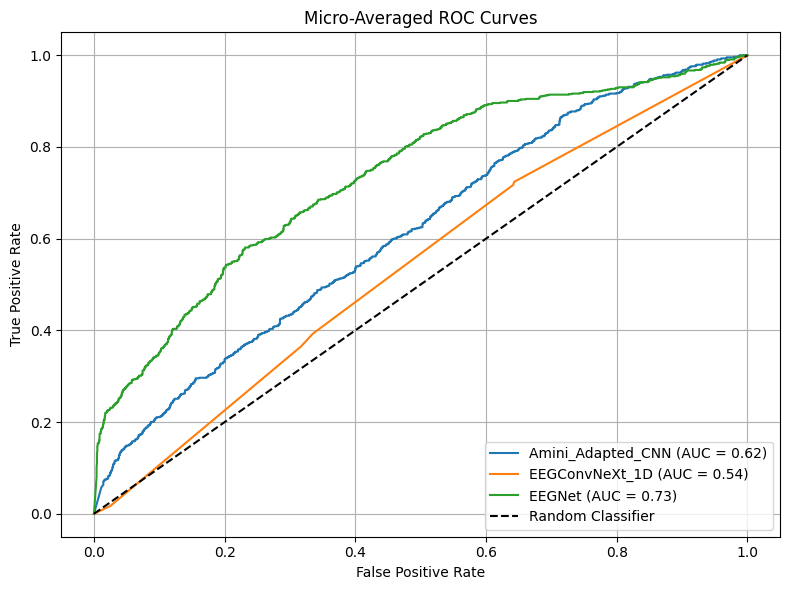

In [39]:
data_loader_to_use = val_loader if val_loader is not None else test_loader
if data_loader_to_use is None:
    raise ValueError("No data available for evaluation.")

all_reports = evaluate_and_compare_models(
    models=model_list,
    model_names=model_names,
    data_loader=data_loader_to_use,
    device=device,
    num_classes=num_classes_actual
)
